In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
plt.style.use("ggplot")



In [2]:
import keras
import tensorflow as tf

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras import backend

from keras.models import Model, Input, Sequential,model_from_json
from keras.layers import SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                         Dropout, Bidirectional, Conv1D, BatchNormalization

print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.3.1
2.0.0


In [3]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

In [4]:
from sklearn.metrics import classification_report
import seaborn as sns

Step 1 
Read ALL DATA


Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity

In [46]:
path_dataset = './data/ner_dataset.csv'
data = pd.read_csv(path_dataset, encoding="latin1")
data = data.fillna(method="ffill")
pd.options.display.max_rows = 999
data.head(15)

Sentence #           Word  POS    Tag
0   Sentence: 1      Thousands  NNS      O
1   Sentence: 1             of   IN      O
2   Sentence: 1  demonstrators  NNS      O
3   Sentence: 1           have  VBP      O
4   Sentence: 1        marched  VBN      O
5   Sentence: 1        through   IN      O
6   Sentence: 1         London  NNP  B-geo
7   Sentence: 1             to   TO      O
8   Sentence: 1        protest   VB      O
9   Sentence: 1            the   DT      O
10  Sentence: 1            war   NN      O
11  Sentence: 1             in   IN      O
12  Sentence: 1           Iraq  NNP  B-geo
13  Sentence: 1            and   CC      O
14  Sentence: 1         demand   VB      O

In [66]:
data['Tag'].loc[(data['Tag'] == 'B-geo')] = 'LOC'
data['Tag'].loc[(data['Tag'] == 'I-geo')] = 'LOC'
data['Tag'].loc[(data['Tag'] == 'B-gpe')] = 'LOC'
data['Tag'].loc[(data['Tag'] == 'I-gpe')] = 'LOC'
data['Tag'].loc[(data['Tag'] == 'B-tim')] = 'TIME'
data['Tag'].loc[(data['Tag'] == 'I-tim')] = 'TIME'
data['Tag'].loc[(data['Tag'] == 'B-org')] = 'ORG'
data['Tag'].loc[(data['Tag'] == 'I-org')] = 'ORG'
data['Tag'].loc[(data['Tag'] == 'B-per')] = 'PER'
data['Tag'].loc[(data['Tag'] == 'I-per')] = 'PER'
data['Tag'].loc[(data['Tag'] == 'B-art')] = 'ART'
data['Tag'].loc[(data['Tag'] == 'I-art')] = 'ART'
data['Tag'].loc[(data['Tag'] == 'B-nat')] = 'ART'
data['Tag'].loc[(data['Tag'] == 'I-nat')] = 'ART'
data['Tag'].loc[(data['Tag'] == 'B-eve')] = 'O'
data['Tag'].loc[(data['Tag'] == 'I-eve')] = 'O'

In [67]:
words = data.Word.unique()

In [68]:
words.sort()

In [69]:
np.where(words=='asking')

(array([17752]),)

In [70]:
words = np.append(words, "ENDPAD")

In [71]:
n_words = len(words)

In [72]:
n_sentences = len(data.groupby('Sentence #'))

In [73]:
tags = data.Tag.unique()
tags.sort()

In [74]:
tags = np.append(tags, "PAD")

In [75]:
n_tags = len(tags)

In [76]:
print('We have {} sentences containing {} unique words with {} different tags.'.format(n_sentences, n_words, n_tags))

We have 47959 sentences containing 35179 unique words with 7 different tags.


In [77]:
print('We have the following Tags: ', tags)

We have the following Tags:  ['ART' 'LOC' 'O' 'ORG' 'PER' 'TIME' 'PAD']


In [78]:
data.Tag.value_counts()

O       888469
LOC      61126
ORG      36927
PER      34241
TIME     26861
ART        951
Name: Tag, dtype: int64

In [79]:
sentence_list = []
max_len = 0
for i, sentence in data.groupby('Sentence #')[['Word', 'Tag']]:
    l = [(x, y) for x, y in zip(sentence.Word, sentence.Tag)]
    sentence_list.append(l)
    max_len = max(max_len, len(l))

In [80]:
print('A sentence: ', sentence_list[100])

A sentence:  [('She', 'O'), ('was', 'O'), ('a', 'O'), ('longtime', 'O'), ('member', 'O'), ('of', 'O'), ('the', 'O'), ('Zapatista', 'LOC'), ('movement', 'O'), ('and', 'O'), ('appeared', 'O'), ('in', 'O'), ('public', 'O'), ('wearing', 'O'), ('a', 'O'), ('black', 'O'), ('ski', 'O'), ('mask', 'O'), ('.', 'O')]


In [81]:
print('Longest sentence length: ', max_len)

Longest sentence length:  104


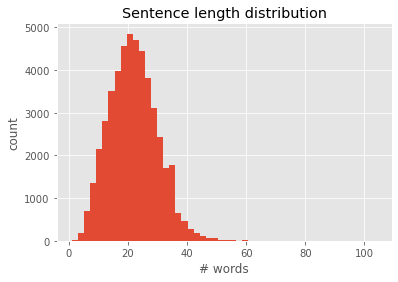

In [82]:
plt.hist([len(s) for s in sentence_list], bins=50)
plt.title('Sentence length distribution')
plt.xlabel('# words')
plt.ylabel('count')
plt.show()

In [83]:
word2idx = {word: idx for idx, word in enumerate(words)}
idx2word = {idx: word for idx, word in enumerate(words)}

In [84]:
print('The index of the work `{}` is {}'.format('Park', word2idx['Park']))

The index of the work `Park` is 11931


In [85]:
X = [[word2idx[w[0]] for w in s] for s in sentence_list]

In [86]:
X = pad_sequences(sequences=X, maxlen=max_len, padding='post', value=n_words-1)

In [87]:
print('The padded sequence for the sentence 0 is: ', X[0])

The padded sequence for the sentence 0 is:  [15077 27700 20969 24218 26434 33389  9684 33464 29396 33246 34660 24853
  8204 17364 20924 33246 34973 27700  4010 33786 23512 33242 20368    24
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]


In [88]:
tag2idx = {tag: idx for idx, tag in enumerate(tags)}
idx2tag = {idx: tag for idx, tag in enumerate(tags)}

In [91]:
print('The index of the tag `{}` is {}'.format('LOC', tag2idx['LOC']))

The index of the tag `LOC` is 1


In [92]:
y = [[tag2idx[w[1]] for w in s] for s in sentence_list]

In [93]:
y = pad_sequences(sequences=y, maxlen=max_len, padding='post', value=tag2idx['PAD'])

In [94]:
print('The padded tags for the sentence 0 is: ', y[0])

The padded tags for the sentence 0 is:  [2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [95]:
y = np.array([to_categorical(i, num_classes=n_tags) for i in y])

In [96]:
y.shape

(47959, 104, 7)

In [97]:
print('The padded categorical tags for the sentence 0 is: ', y[0])

The padded categorical tags for the sentence 0 is:  [[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

In [99]:
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


In [102]:
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx['LOC']))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

The index of tag 'B-gpe' is: 1

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 7)


In [103]:
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [104]:
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

In [105]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [106]:
def pred2label(pred):
    labels = []
    for pred_i in pred:
        label = []
        for p in pred_i:
            p_i = np.argmax(p)
            label.append(idx2tag[p_i])
        labels.append(label)
    return np.array(labels).flatten()

In [107]:
def compute_f1_score(model_name, X, y):
    if model_name=='baseline':
        preds = baseline[X]
    else:
        model = load_keras_model(model_name)
        preds = model.predict(X)
    pred_labels = pred2label(preds)
    print("{}: F1-score: {:.1%}".format(model_name, f1_score(y, pred_labels, average='weighted')))
    f1_scores = classification_report(y, pred_labels, output_dict=True)
    df = pd.DataFrame(f1_scores)[tags].reset_index().rename(columns={'index': 'Metric'})
    df = pd.melt(df, id_vars=["Metric"], 
                       var_name="Tag", value_name="Value")
    df = df[['Tag', 'Metric','Value']]
    df['Model'] = model_name
    return df, pred_labels

In [108]:
word_tag_count = np.zeros((n_words, n_tags))
for i in range(X_train.shape[0]):
    for j in range(X_train[i].shape[0]):
        word_tag_count[X_train[i][j]][y_train[i][j]==1] += 1

In [109]:
baseline =  word_tag_count
#baseline = [np.argmax(a) for a in word_tag_count]

In [110]:
baseline = np.array(baseline)

In [111]:
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in np.argmax(baseline[X[0]],axis=-1)]))

(47959, 104, 7) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'E

In [112]:
import warnings
warnings.filterwarnings('ignore') 

models = ['baseline', 'model_FFNN', 'model_RNN', 'model_GRU', 'model_BiGRU']

test_labels = pred2label(y_test)
df_predictions =$ pd.DataFrame()
df_predictions['Word'] = [idx2word[w] for w in X_test.reshape(-1,)]
df_predictions['y_true'] = test_labels

df_f1_scores = pd.DataFrame(columns=['Model', 'Tag', 'Metric', 'Value'])

for i in range(len(models)):
    f1, pred_labels = compute_f1_score(models[i], X_test, test_labels)
    df_f1_scores = df_f1_scores.append(f1, sort=False)
    df_predictions[models[i]] = pred_labels

SyntaxError: invalid syntax (<ipython-input-112-c7fc5168e1ab>, line 7)

In [48]:
def plot_f1_scores(df_f1_scores):
    fig, ax = plt.subplots(1,1,figsize=(20,7))
    sns.barplot(data=df_f1_scores[(df_f1_scores.Metric=='f1-score') & (~df_f1_scores.Tag.isin(['PAD']))], x='Tag', y='Value', hue='Model', ax=ax)
    plt.xticks(fontsize=14)
    ax.set_ylabel('F1 Score')
    ax.set_title('F1 Scores per Tag and Model');

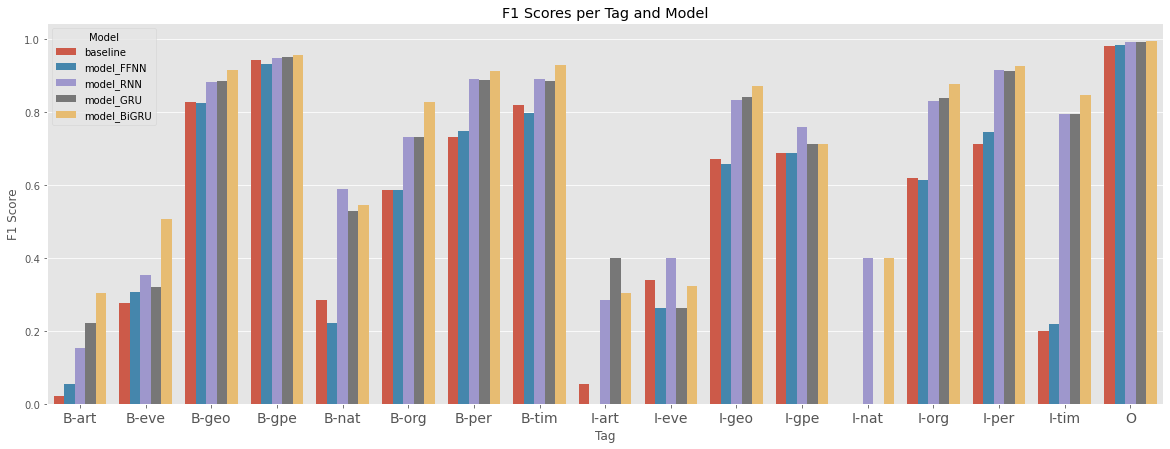

In [49]:
plot_f1_scores(df_f1_scores)

In [50]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [51]:
df_predictions_wrong = df_predictions[(df_predictions.y_true!=df_predictions.baseline) |
                                        (df_predictions.y_true!=df_predictions.model_FFNN) |
                                        (df_predictions.y_true!=df_predictions.model_RNN) |
                                        (df_predictions.y_true!=df_predictions.model_GRU) |
                                        (df_predictions.y_true!=df_predictions.model_BiGRU)]

In [52]:
df_predictions_wrong.style.apply(highlight_errors, axis=1)

In [53]:
len(df_predictions_wrong)

7388

In [54]:
df_f1_scores[(df_f1_scores.Metric=='f1-score') & 
             (df_f1_scores.Tag.isin(['B-art','I-art','B-eve','I-eve','B-nat','I-nat'])) & 
             (df_f1_scores.Model=='model_BiGRU')]

Model    Tag    Metric     Value
2   model_BiGRU  B-art  f1-score  0.304348
6   model_BiGRU  B-eve  f1-score  0.508475
18  model_BiGRU  B-nat  f1-score  0.545455
34  model_BiGRU  I-art  f1-score  0.303030
38  model_BiGRU  I-eve  f1-score  0.324324
50  model_BiGRU  I-nat  f1-score  0.400000